In [5]:
from bhpwave.spline import CubicSpline, BicubicSpline
from bhpwave.trajectory.geodesic import kerr_isco_frequency, kerr_circ_geo_radius

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)
mpl.rc('font', **{'size' : 14})

import os
pathname=os.path.abspath("")

OMEGA_MIN = 2.e-3
A_MAX = 0.9999

def alpha_of_a_omega(a, omega):
    oISCO = kerr_isco_frequency(a)
    return alpha_of_omega_ISCO(omega, oISCO)

def alpha_of_omega_ISCO(omega, oISCO):
    return (abs(oISCO**(1./3.) - omega**(1./3.))/(oISCO**(1./3.) - OMEGA_MIN**(1./3.)))**(0.5)

def omega_of_a_alpha(a, alpha):
    oISCO = kerr_isco_frequency(a)
    return omega_of_alpha_ISCO(alpha, oISCO)

def omega_of_alpha_ISCO(alpha, oISCO):
    return pow(pow(oISCO, 1./3.) - pow(alpha, 2.)*(pow(oISCO, 1./3.) - pow(OMEGA_MIN, 1./3.)), 3.)

def chi_of_spin_subfunc(a):
    return pow(1. - a, 1./3.)

def chi_of_spin(a):
    return pow((chi_of_spin_subfunc(a) - chi_of_spin_subfunc(A_MAX))/(chi_of_spin_subfunc(-A_MAX) - chi_of_spin_subfunc(A_MAX)), 0.5)

def spin_of_chi(chi):
    return 1. - pow(chi_of_spin_subfunc(A_MAX) + pow(chi, 2.)*(chi_of_spin_subfunc(-A_MAX) - chi_of_spin_subfunc(A_MAX)), 3.)

def a_omega_to_chi_alpha(a, omega):
    chi = chi_of_spin(a)
    alpha = alpha_of_a_omega(a, omega)
    return (chi, alpha)

def pn_flux_noprefactor(omega):
    return omega**(10./3.)

def pn_time_noprefactor(a, omega):
    oISCO = kerr_isco_frequency(a)
    offset = oISCO**(-8/3) + 1.e-6
    return -np.abs(offset - omega**(-8./3.))

def pn_phase_noprefactor(a, omega):
    oISCO = kerr_isco_frequency(a)
    offset = oISCO**(-5/3) + 1.e-6
    return -np.abs(offset - omega**(-5./3.))

def pn_flux_noprefactor_domega(omega):
    return (10./3.)*omega**(7./3.)

def pn_time_noprefactor_domega(omega):
    return -(-8/3)*omega**(-11./3.)

def pn_phase_noprefactor_domega(omega):
    return -(-5/3)*omega**(-8./3.)

def load_trajectory_data_file(filepath):
    traj = np.loadtxt(filepath, skiprows=3)
    #trajHeader = np.loadtxt(filepath, skiprows=2, max_rows=1, dtype='str')
    trajShape = np.loadtxt(filepath, skiprows=1, max_rows=1, dtype='int')

    fluxDataTemp = np.ascontiguousarray(traj[:, 2].reshape(trajShape[:2]))
    alphaDataFluxTemp = np.ascontiguousarray(traj[:, 1].reshape(trajShape[:2])[0])
    chiDataFluxTemp = np.ascontiguousarray(traj[:, 0].reshape(trajShape[:2])[:, 0])

    phaseData = np.ascontiguousarray(traj[:, 4].reshape(trajShape[:2]))
    timeData = np.ascontiguousarray(traj[:, 3].reshape(trajShape[:2]))
    alphaData = np.ascontiguousarray(traj[:, 1].reshape(trajShape[:2])[0])
    chiData = np.ascontiguousarray(traj[:, 0].reshape(trajShape[:2])[:, 0])
    betaData = np.ascontiguousarray(traj[:, 5].reshape(trajShape[:2])[0])
    omegaData = np.ascontiguousarray(traj[:, 6].reshape(trajShape[:2]))
    phaseBetaData = np.ascontiguousarray(traj[:, 7].reshape(trajShape[:2]))

    fluxDownsampleChi = int((trajShape[0] - 1)/(trajShape[2] - 1))
    fluxDownsampleAlpha = int((trajShape[1] - 1)/(trajShape[3] - 1))

    fluxData = fluxDataTemp[::fluxDownsampleChi, ::fluxDownsampleAlpha]
    alphaDataFlux = alphaDataFluxTemp[::fluxDownsampleAlpha]
    chiDataFlux = chiDataFluxTemp[::fluxDownsampleChi]

    return chiData, alphaData, timeData, phaseData, betaData, omegaData, phaseBetaData, chiDataFlux, alphaDataFlux, fluxData

traj_data_full = load_trajectory_data_file(pathname+"/../data/trajectory.txt")

timeData_temp = traj_data_full[2]
phaseData_temp = traj_data_full[3]

chiData = traj_data_full[7]
alphaData = traj_data_full[8]
fluxData = traj_data_full[9]

downsample_chi = int((phaseData_temp.shape[0] - 1)/(fluxData.shape[0] - 1))
downsample_alpha = int((phaseData_temp.shape[1] - 1)/(fluxData.shape[1] - 1))
phaseData = phaseData_temp[::downsample_chi, ::downsample_alpha]
timeData = timeData_temp[::downsample_chi, ::downsample_alpha]

Edot = BicubicSpline(chiData, alphaData, fluxData)
PhiCheck = BicubicSpline(chiData, alphaData, phaseData)
TCheck = BicubicSpline(chiData, alphaData, timeData)

downsample_rate = 4
Nb = int((chiData.shape[0] - 1)/downsample_rate + 1)
Na = int((alphaData.shape[0] - 1)/downsample_rate + 1)
flux_samples = np.zeros((Nb, Na, 5))
phase_samples = np.zeros((Nb, Na, 5))
time_samples = np.zeros((Nb, Na, 5))
for i in range(Nb):
    for j in range(Na):
        chi = chiData[downsample_rate*i]
        alpha = alphaData[downsample_rate*j]
        atemp = spin_of_chi(chi)
        otemp = omega_of_a_alpha(atemp, alpha)
        EdotData = Edot(chi, alpha)
        PData = PhiCheck(chi, alpha)
        TData = TCheck(chi, alpha)
        flux_samples[i, j] = [atemp, otemp, EdotData, alpha, chi]
        phase_samples[i, j] = [atemp, otemp, PData, alpha, chi]
        time_samples[i, j] = [atemp, otemp, TData, alpha, chi]

In [7]:
time_samples[20,20]

array([ 0.85904034,  0.15743033, -0.58495866,  0.3125    ,  0.625     ])

In [10]:
pn_time_noprefactor(0.9411845318952371, 0.16569872100996472)

85.59816824968382

In [13]:
kerr_isco_frequency(0.9411845318952371)**(-5/3) - (0.16569872100996472)**(-5/3)

-10.75648372334578

Saving figure to /Users/znasipak/Documents/Papers/bhpwave_2023/bhpwave-article/scripts/../figures/boundary_condition_comparison.pdf


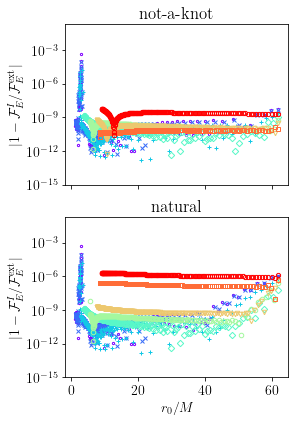

In [7]:
from bhpwave.spline import BicubicSpline
from bhpwave.trajectory.geodesic import kerr_isco_frequency, kerr_circ_geo_orbital_frequency

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)
mpl.rc('font', **{'size' : 14})

import os
pathname = "/Users/znasipak/Documents/Papers/bhpwave_2023/bhpwave-article/scripts"

OMEGA_MIN = 2.e-3
A_MAX = 0.9999

def alpha_of_a_omega(a, omega):
    oISCO = kerr_isco_frequency(a)
    return alpha_of_omega_ISCO(omega, oISCO)

def alpha_of_omega_ISCO(omega, oISCO):
    return (abs(oISCO**(1./3.) - omega**(1./3.))/(oISCO**(1./3.) - OMEGA_MIN**(1./3.)))**(0.5)

def omega_of_a_alpha(a, alpha):
    oISCO = kerr_isco_frequency(a)
    return omega_of_alpha_ISCO(alpha, oISCO)

def omega_of_alpha_ISCO(alpha, oISCO):
    return pow(pow(oISCO, 1./3.) - pow(alpha, 2.)*(pow(oISCO, 1./3.) - pow(OMEGA_MIN, 1./3.)), 3.)

def chi_of_spin_subfunc(a):
    return pow(1. - a, 1./3.)

def chi_of_spin(a):
    return pow((chi_of_spin_subfunc(a) - chi_of_spin_subfunc(A_MAX))/(chi_of_spin_subfunc(-A_MAX) - chi_of_spin_subfunc(A_MAX)), 0.5)

def spin_of_chi(chi):
    return 1. - pow(chi_of_spin_subfunc(A_MAX) + pow(chi, 2.)*(chi_of_spin_subfunc(-A_MAX) - chi_of_spin_subfunc(A_MAX)), 3.)

def a_omega_to_chi_alpha(a, omega):
    chi = chi_of_spin(a)
    alpha = alpha_of_a_omega(a, omega)
    return (chi, alpha)

bhptoolkit_file_location = "https://raw.githubusercontent.com/BlackHolePerturbationToolkit/CircularOrbitSelfForceData/548664620a3f35ce1cd8e55c70b891dede76abee/Kerr/Fluxes/Flux_Edot_a"
flux_spin_list = [0.999, 0.995, 0.9, 0.6, 0.1, -0.5, -0.8, -0.99]
flux_file_list = []
for spin in flux_spin_list:
    aval = str(spin)
    datapath = pathname + "/../data/"
    file_check = datapath + "Flux_Edot_a" + aval + ".dat"
    wget_string = "wget -P " + datapath + " " + bhptoolkit_file_location + aval + ".dat"
    flux_file_list.append(file_check)
    if not os.path.isfile(file_check):
        print("Get " + file_check)
        os.system(wget_string)

traj = np.loadtxt(pathname + "/../data/trajectory_downsample.txt", skiprows=3)
trajHeader = np.loadtxt(pathname + "/../data/trajectory_downsample.txt", skiprows=2, max_rows=1, dtype='str')
trajShapeFull = np.loadtxt(pathname + "/../data/trajectory_downsample.txt", skiprows=1, max_rows=1, dtype='int')
trajShape = trajShapeFull[:2]
fluxShape = trajShapeFull[2:]

phaseData = np.ascontiguousarray(traj[:, 4].reshape(trajShape))
timeData = np.ascontiguousarray(traj[:, 3].reshape(trajShape))
chiData = np.ascontiguousarray(traj[:, 0].reshape(trajShape)[:, 0])
alphaData = np.ascontiguousarray(traj[:, 1].reshape(trajShape)[0])

downsample1 = int(trajShape[0]/fluxShape[0])
downsample2 = int(trajShape[1]/fluxShape[1])
chiFluxData = chiData[::downsample1]
alphaFluxData = alphaData[::downsample2]
fluxData = np.ascontiguousarray(traj[:, 2].reshape(fluxShape))

alphaa, aa = np.meshgrid(alphaFluxData, spin_of_chi(chiFluxData))
omegaa = omega_of_a_alpha(aa, alphaa)

spl=BicubicSpline(np.linspace(0, 1, 129), np.linspace(0, 1, 257), fluxData/(32./5.*omegaa**(10./3.)), bc="E(3)")
spl2=BicubicSpline(np.linspace(0, 1, 129), np.linspace(0, 1, 257), fluxData/(32./5.*omegaa**(10./3.)), bc="natural")
spl3=BicubicSpline(np.linspace(0, 1, 129), np.linspace(0, 1, 257), fluxData/(32./5.*omegaa**(10./3.)), bc="not-a-knot")
def scaled_energy_flux(a, r0, bc="E(3)"):
    omega = kerr_circ_geo_orbital_frequency(a, r0)
    alpha = alpha_of_a_omega(a, omega)
    chi = chi_of_spin(a)
    if bc == "E(3)":
        return spl(chi, alpha)*32./5.*omega**(10./3.)
    elif bc == "natural":
        return spl2(chi, alpha)*32./5.*omega**(10./3.)
    elif bc == "not-a-knot":
        return spl3(chi, alpha)*32./5.*omega**(10./3.)
    else:
        return spl(chi, alpha)*32./5.*omega**(10./3.)

testData = []
for file, spin in zip(flux_file_list, flux_spin_list):
    tempData = np.loadtxt(file)
    tempData = tempData[tempData[:,0] < 62.]
    testData.append([spin, tempData])

N = len(testData)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.rainbow(np.linspace(0,1,N)))

bc_array = ["not-a-knot", "natural"]
markers = ['.', 'x', '+', 'D', 'o', 'v', 's', '8']
fig, axs = plt.subplots(len(bc_array), 1, sharex=True)
fig.set_size_inches(4., 6.5)

i = 0
for bc in bc_array:
    comparisons = []
    for data in testData:
        a = data[0]
        compData = data[1]
        r_vals = compData[:, 0]
        flux_vals = compData[:, 1] + compData[:, 2]
        flux_comparison = np.zeros((r_vals.shape[0]))
        for j in range(flux_comparison.shape[0]):
            flux_comparison[j] = scaled_energy_flux(a, r_vals[j], bc=bc)
        comparisons.append([r_vals, np.abs(1. - flux_comparison/flux_vals)])
    
    for j, comparison in enumerate(comparisons):
        axs[i].plot(comparison[0][::32], comparison[1][::32], markers[j], label="$"+str(flux_spin_list[j])+"$", markersize = 4.5, fillstyle='none')
    axs[i].set_yscale('log')
    # if i == 0:
    #     axs[i].legend(loc="upper right", ncol=2)
    axs[i].set_ylabel('$|1 - {\mathcal{F}_E^I}/{\mathcal{F}_E^\mathrm{ext}}|$')
    axs[i].set_title(bc)
    axs[i].set_ylim(1.e-15, 2.e-1)
    i += 1 
axs[i-1].set_xlabel('$r_0/M$')

fig_name = "boundary_condition_comparison"
print("Saving figure to " + pathname + "/../figures/" + fig_name + ".pdf")
#plt.savefig(pathname+"/../figures/" + fig_name + ".pdf", bbox_inches="tight", dpi=300)
plt.show()